In [1]:
# import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img=np.random.rand(1,1,10,10)
ker=np.random.rand(1,1,3,3)

In [3]:
# '''
# All the cooresponding receptive feilds locations are stored in a cloumn in matrix
# 00  01 ....
# 01  02 ....
# 02  03 ....   ____________________
# 10  11 ....   |  00 |  01 |  02  |
# 11  12 ....   |-----|-----|------| 
# 12  13 ....   |  10 |  11 |  12  |
# 20  21 ....   |-----|-----|------|
# 21  22 ....   |  20 |  21 |  22  |             
# 22  23 ....   |_____|_____|______|                   
# '''

In [4]:
class class_conv():
    def __init__(self, img, ker, b, pad=1, stride=1):
        
        self.img_b, self.img_d, self.img_h, self.img_w=img.shape
        self.ker_b, self.ker_d, self.ker_h, self.ker_w=ker.shape
        self.b, self.pad, self.stride, self.img, self.ker=b, pad, stride, img, ker
        
    def __call__(self):
        self.out=self.forward(self.img, self.ker)
        return self.out
    
    def forward(self): raise Exception('Not Implemented')
    def backward(self): return self.bwd(self.out)

In [5]:
class cunny(class_conv):
    def forward(self, img, ker):
        self.out_h= int((self.img_h-self.ker_h)+(2*self.pad)/self.stride) +1
        self.out_w= int((self.img_w-self.ker_w)+(2*self.pad)/self.stride) +1

        pad_img=np.pad(img, ((0,0),(0,0),(1,1),(1,1)),mode='constant')

        i0=np.repeat(np.arange(self.ker_h), self.ker_h)
        i1=np.repeat(np.arange(self.img_h), self.img_h)
        j0=np.tile(np.arange(self.ker_w), self.ker_h)
        j1=np.tile(np.arange(self.img_h), self.img_w)
        self.i=i0.reshape(-1,1)+i1.reshape(1,-1)
        self.j=j0.reshape(-1,1)+j1.reshape(1,-1)
        self.k=np.repeat(np.arange(self.img_d), self.ker_h*self.ker_w).reshape(-1,1)

        self.select_img=pad_img[:,:,self.i,self.j].squeeze()      #[1,9,100] gets converted to [9,100]
        weights=ker.reshape(self.ker_h*self.ker_w, -1)       #weights gets converted to [9,1]
        convolve=weights.transpose()@self.select_img    # [1,9] * [9,100] ----> [1,100]
        convolve=convolve.reshape(1,1,10,10)       # [1,1,10,10]
        return convolve
    
    def bwd(self, out):
        
        out_h= self.img_h + 2 * self.pad 
        out_w= self.img_w + 2 * self.pad

        db=np.sum(out, axis=(0,2,3))
        db=db.reshape(self.ker_b, -1)

        out_reshape=out.squeeze().reshape(self.ker_b, -1)
        dw=out_reshape @ self.select_img.T
        dw=dw.reshape(ker.shape)

        ker_reshape=self.ker.reshape(self.ker_b, -1)
        X= ker_reshape.T @ out_reshape

        padded=np.zeros((self.img_b, self.img_d, out_h, out_w), dtype=X.dtype)
        X_reshaped=X.reshape(self.ker_h*self.ker_w, -1, self.ker_b)
        X_reshaped=X_reshaped.transpose(2,0,1)

        np.add.at(padded, (slice(None), self.k, self.i, self.j), X_reshaped)
        dX=padded[:,:,self.pad:-self.pad, self.pad:-self.pad]

        return dX, dw, db

In [6]:
c=cunny(img, ker, 0)

In [7]:
forward=c()

In [8]:
inp_g, we_g, bias_g=c.backward()

In [9]:
# forward.shape

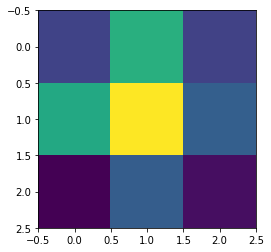

In [10]:
plt.imshow(we_g.squeeze())